# Model Explainability
In this step we reuse some code [from step 2](../02-sagemaker-containers.ipynb) to inspect our model with SageMaker Clarify both in batch inference as in a real-time endpoint. 

![](../img/six-steps-2.png)

Model explainability has become a critical topic in the field of artificial intelligence, as the complexity of machine learning models has increased rapidly. Explainability refers to the ability to understand and interpret the decision-making process of a model, which is essential in making informed decisions and gaining trust in the model's predictions. SHAP (Shapley Additive Explanations) is a popular method for model explainability that has gained significant attention in recent years.

SHAP is a unified framework that provides a game-theoretic approach to explain the output of any machine learning model. It uses Shapley values, a concept from cooperative game theory, to attribute the contribution of each feature to the model's output. SHAP has been shown to be effective in providing both global and local interpretability, allowing users to understand the overall behavior of the model and the reasoning behind specific predictions.

However, the computational problem of SHAP lies in its complexity. SHAP values require the computation of all possible coalitions of features, which is an NP-hard problem. To address this challenge, several approximation methods have been proposed, including Kernel SHAP, Tree SHAP, and Deep SHAP. These methods use different techniques to approximate the SHAP values efficiently and accurately, making SHAP a practical solution for model explainability in real-world scenarios.

SageMaker Clarify addresses this issue by providing a distributed and scalable implementation of SHAP that runs on Apache Spark in the background. It uses a processing job to run the SHAP algorithm on a cluster of EC2 instances, enabling the computation of SHAP values to be distributed across multiple nodes. This greatly reduces the time required for SHAP computations, making it practical to use for large datasets and complex models.

In [ ]:
# use sys executable to install shap via pip
import sys
import subprocess
subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])

In [3]:
import time
import boto3
import botocore
import os
import numpy as np  
import pandas as pd  
import sagemaker
import io
from collections import OrderedDict
from time import gmtime, strftime, sleep
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sklearn.metrics import roc_auc_score
from sagemaker.experiments.run import Run, load_run
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer, CSVDeserializer

json_deserializer = JSONDeserializer()
csv_serializer = CSVSerializer()
csv_deserializer = CSVDeserializer()

sagemaker.__version__

'2.145.0'

In [4]:
%store -r 

%store

try:
    initialized
except NameError:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN 00-start-here notebook   ")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")

Stored variables and their in-db values:
baseline_s3_url                          -> 's3://sagemaker-us-east-1-510646607739/from-idea-t
bucket_name                              -> 'sagemaker-us-east-1-510646607739'
bucket_prefix                            -> 'from-idea-to-prod/xgboost'
customers_count                          -> 10000
customers_feature_group_name             -> 'fscw-customers-01-19-17-06'
domain_id                                -> 'd-pradjcre65nc'
endpoint_name                            -> 'reorder-classifier-2023-01-03-10-39-39-444'
initialized                              -> True
input_s3_url                             -> 's3://sagemaker-us-east-1-510646607739/from-idea-t
orders_count                             -> 100000
orders_feature_group_name                -> 'fscw-orders-01-19-17-06'
products_count                           -> 17001
products_feature_group_name              -> 'fscw-products-01-19-17-06'
query_string                             -> 'SELECT *

In [5]:
session = sagemaker.Session()
sm = session.sagemaker_client

Set the Amazon S3 paths:


In [6]:
train_s3_url = f"s3://{bucket_name}/{bucket_prefix}/train"
validation_s3_url = f"s3://{bucket_name}/{bucket_prefix}/validation"
test_s3_url = f"s3://{bucket_name}/{bucket_prefix}/test"
baseline_s3_url = f"s3://{bucket_name}/{bucket_prefix}/baseline"
output_s3_url = f"s3://{bucket_name}/{bucket_prefix}/output"

In [7]:
%store train_s3_url
%store validation_s3_url
%store test_s3_url
%store baseline_s3_url
%store output_s3_url

Stored 'train_s3_url' (str)
Stored 'validation_s3_url' (str)
Stored 'test_s3_url' (str)
Stored 'baseline_s3_url' (str)
Stored 'output_s3_url' (str)


## Model training
Follow the same approach and now run the model training as a [SageMaker training job](https://sagemaker.readthedocs.io/en/stable/overview.html#using-estimators).

In [8]:
# get training container uri
training_image = sagemaker.image_uris.retrieve("xgboost", region=region, version="1.5-1")

print(training_image)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.5-1


Define the data input channels for the training job. Set _train_ and _validation_ channels via the SageMaker SDK [`TrainingInput`](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html#sagemaker.inputs.TrainingInput) class:

In [9]:
s3_input_train = sagemaker.inputs.TrainingInput(train_s3_url, content_type='csv')
s3_input_validation = sagemaker.inputs.TrainingInput(validation_s3_url, content_type='csv')

In [10]:
train_instance_count = 1
train_instance_type = "ml.m5.xlarge"

Instantiate an [Estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) object and set algorithm's hyperparameters. Refer to [XGBoost hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost_hyperparameters.html) for more information.

In [11]:
# Instantiate an XGBoost estimator object
estimator = sagemaker.estimator.Estimator(
    image_uri=training_image,  # XGBoost algorithm container
    instance_type=train_instance_type,  # type of training instance
    instance_count=train_instance_count,  # number of instances to be used
    role=sm_role,  # IAM execution role to be used
    max_run=20 * 60,  # Maximum allowed active runtime
    use_spot_instances=True,  # Use spot instances to reduce cost
    max_wait=30 * 60,  # Maximum clock time (including spot delays)
    output_path=output_s3_url, # S3 location for saving the training result
    sagemaker_session=session, # Session object which manages interactions with SageMaker API and AWS services
    base_job_name="from-idea-to-prod-training", # Prefix for training job name
)

# define its hyperparameters
estimator.set_hyperparameters(
    num_round=150, # the number of rounds to run the training
    max_depth=3, # maximum depth of a tree
    eta=0.5, # step size shrinkage used in updates to prevent overfitting
    alpha=2.5, # L1 regularization term on weights
    objective="binary:logistic",
    eval_metric="auc", # evaluation metrics for validation data
    subsample=0.8, # subsample ratio of the training instance
    colsample_bytree=0.8, # subsample ratio of columns when constructing each tree
    min_child_weight=3, # minimum sum of instance weight (hessian) needed in a child
    early_stopping_rounds=10, # the model trains until the validation score stops improving
    verbosity=1, # verbosity of printing messages
)

Now we can either train a model, or retrieve our last training job from the workshop before. 

In [12]:
training_inputs = {'train': s3_input_train, 'validation': s3_input_validation}

In [18]:
try:
    experiment_name
except NameError:
    print("the experiment name was not set, therefore defining a new one!")
    experiment_name = f"from-idea-to-prod-experiment-{strftime('%d-%H-%M-%S', gmtime())}"
    print(f"new experiment name is: {experiment_name}")

In [20]:
try:
    run_suffix = strftime('%Y-%m-%M-%S', gmtime())
    run_name = f"container-training-{run_suffix}"

    with Run(experiment_name=experiment_name,
             run_name=run_name,
             run_display_name="training-model-explainability",
             sagemaker_session=session
            ) as run:
        
        estimator.fit(
            training_inputs,
            wait=True,
            logs=False,
        ) 
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == 'AccessDeniedException':
        print(f"Ignore AccessDeniedException: {e.response['Error']['Message']} because of the slow resource tag auto propagation")
    else:
        raise e

INFO:sagemaker:Creating training-job with name: from-idea-to-prod-training-2023-04-18-11-57-33-137



2023-04-18 11:57:33 Starting - Starting the training job..
2023-04-18 11:57:49 Starting - Preparing the instances for training........
2023-04-18 11:58:34 Downloading - Downloading input data.....
2023-04-18 11:59:05 Training - Downloading the training image...
2023-04-18 11:59:25 Training - Training image download completed. Training in progress.........
2023-04-18 12:00:14 Uploading - Uploading generated training model..
2023-04-18 12:00:25 Completed - Training job completed


### Output model performance

In [21]:
if estimator._current_job_name:
    training_job_name = estimator._current_job_name

In [22]:
metrics = None
while not metrics:
    metrics = sm.describe_training_job(
        TrainingJobName=training_job_name
        ).get("FinalMetricDataList")

    if not metrics:
        print(f"Training job {training_job_name} hasn't finished yet!")
        time.sleep(10)
    
train_auc = float([m['Value'] for m in metrics if m['MetricName'] == 'train:auc'][0])
validate_auc = float([m['Value'] for m in metrics if m['MetricName'] == 'validation:auc'][0])

print(f"Train-auc:{train_auc:.2f}, Validate-auc:{validate_auc:.2f}")

Train-auc:0.79, Validate-auc:0.77


In [23]:
%store training_job_name

Stored 'training_job_name' (str)


In [24]:
# Print the S3 path to the model artifact:
estimator.model_data

's3://sagemaker-us-east-1-510646607739/from-idea-to-prod/xgboost/output/from-idea-to-prod-training-2023-04-18-11-57-33-137/output/model.tar.gz'

### Loading the model from the training job
Alternatively, you can load a model from a model artifact produced by a training job. You create a transformer with that model.

In [71]:
model = session.create_model_from_job(
    training_job_name=training_job_name, 
    name=model_name,
)

INFO:sagemaker:Creating model with name: from-idea-to-prod-transform-18-19-55-14


In [72]:
transformer = sagemaker.transformer.Transformer(
    model_name=model,
    instance_count=1,
    instance_type=train_instance_type,
    accept="text/csv",
    assemble_with="Line",
    output_path=transform_s3_url,
    base_transform_job_name="from-idea-to-prod-trasform",
    sagemaker_session=session,
)

#### Run transform job

In [73]:
transform_job_name = f"from-idea-to-prod-transform-{strftime('%d-%H-%M-%S', gmtime())}"

try:
    run_suffix = strftime('%Y-%m-%M-%S', gmtime())
    run_name = f"batch-transform-{run_suffix}"

    with Run(experiment_name=experiment_name,
             run_name=run_name,
             run_display_name="batch-transform",
             sagemaker_session=session
            ) as run:
        transformer.transform(    
            data=f"{test_s3_url}/test_x.csv",
            content_type="text/csv",
            split_type="Line", 
            job_name=transform_job_name,
            wait=True,
            # experiment_config=experiment_config,
        )
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == 'AccessDeniedException':
        print(f"Ignore AccessDeniedException: {e.response['Error']['Message']} because of the slow resource tag auto propagation")
    else:
        raise e

INFO:sagemaker:Creating transform job with name: from-idea-to-prod-transform-18-19-55-22


..........................[2023-04-18:19:59:44:INFO] No GPUs detected (normal if no gpus installed)
[2023-04-18:19:59:44:INFO] No GPUs detected (normal if no gpus installed)
[2023-04-18:19:59:44:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2023-04-18 19:59:45 +0000] [19] [INFO] Starting gunicorn 

In [74]:
while sm.describe_transform_job(
        TransformJobName=transformer._current_job_name
    )["TransformJobStatus"] != "Completed":
    time.sleep(10)
    print(f"Wait until {transformer._current_job_name} completed")

In [75]:
transformer.output_path

's3://sagemaker-us-east-1-510646607739/from-idea-to-prod/xgboost/transform'

#### Evaluate predictions

In [76]:
!aws s3 ls {transformer.output_path}/

2023-04-18 19:59:50      82337 test_x.csv.out


In [77]:
!aws s3 cp {transformer.output_path}/test_x.csv.out tmp/predictions.csv
!aws s3 cp $test_s3_url/test_y.csv tmp/test_y.csv

download: s3://sagemaker-us-east-1-510646607739/from-idea-to-prod/xgboost/transform/test_x.csv.out to tmp/predictions.csv
download: s3://sagemaker-us-east-1-510646607739/from-idea-to-prod/xgboost/test/test_y.csv to tmp/test_y.csv


In [78]:
predictions = pd.read_csv("tmp/predictions.csv", names=["y_prob"])
test_y = pd.read_csv("tmp/test_y.csv", names=['y'])

#### Crosstab

In [79]:
pd.crosstab(
    index=test_y['y'].values,
    columns=np.array(np.round(predictions), dtype=float).squeeze(), 
    rownames=['actuals'], 
    colnames=['predictions']
)

predictions,0.0,1.0
actuals,,
0,3602,34
1,401,82


In [80]:
test_auc = roc_auc_score(test_y, predictions)
print(f"Test-auc: {test_auc:.2f}")

Test-auc: 0.77


In [104]:
# reading the feature headers from the feature_headers.txt file 
# opening the file in read mode
feature_header_file = open("feature_headers.txt", "r")

# reading the file
data = feature_header_file.read()

# replacing end splitting the text
# when newline ('\n') is seen.
feature_headers_list = data.split(",")
print(feature_headers_list)
feature_header_file.close()


['y', 'age', 'campaign', 'pdays', 'previous', 'no_previous_contact', 'not_working', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed', 'poutcome_failure', 'poutcome_non

## Model Bias and Explainability with SageMaker Clarify 
You can use SageMaker Clarify to analyze your datasets and models for explainability and bias. A SageMaker Clarify Processing job uses the SageMaker Clarify Processing container to interact with an Amazon S3 bucket containing your input datasets. You can also use SageMaker Clarify to analyze a customer model that is deployed to a SageMaker inference endpoint.

The following graphic shows how a SageMaker Clarify Processing job interacts with your input data and optionally, with a customer model. This interaction depends on the specific type of analysis being performed. The SageMaker Clarify Processing container obtains the input dataset and configuration for analysis from an S3 bucket. For certain analysis types, including feature analysis, the SageMaker Clarify Processing container must send requests to the model container. Then it retrieves the model predictions from the response that the model container sends. After that, the SageMaker Clarify Processing container computes and saves analysis results to the S3 bucket. Please note that Clarify will automatically create and tear down inference endpoints for batch processes. Online explainability shows a different architecture and will be covered at the end of the section. 

![Clarify Processor Image](../img/ClarifyProcessor.png)

You can run a SageMaker Clarify Processing job at multiple stages in the lifecycle of the machine learning workflow. SageMaker Clarify can help you compute the following analysis types:

[Pre-training bias metrics](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-measure-data-bias) can help you understand the bias in your data so that you can address it and train your model on a more fair dataset. To run a job to analyze pre-training bias metrics, you must provide the dataset and a JSON analysis configuration file to Configure the Analysis.

[Post-training bias metrics](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-measure-post-training-bias.html) can help you understand any bias introduced by an algorithm, hyperparameter choices, or any bias that wasn't apparent earlier in the flow. SageMaker Clarify uses the model predictions in addition to the data and labels to identify bias. To run a job to analyze post-training bias metrics, you must provide the dataset and a JSON analysis configuration file. The configuration should include the model or endpoint name.

[SHAP values for explainability](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-shapley-values.html) can help you understand what impact your feature has on what your model predicts. This feature requires a trained model.

[Online Explainability with SageMaker Clarify](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-online-explainability.html) lets you analyze explainability for SageMaker real-time inference endpoints in real time, continuously. The online explainability function fits into the Deploy to production part of the Amazon SageMaker Machine Learning workflow.

[Partial dependence plots (PDP)](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-partial-dependence-plots.html) can help you understand how much your predicted target variable would change if you varied the value of one feature. This feature requires a trained model.

In the following section we will deep dive into the first four options presented. 


### Pre- and post training bias
To inspect pre-and post data we can use the SageMaker Clarify bias report. 

We will run through the example with our dataset at hand, however it should be noted, that in our example, we are not really running the risk of putting a customer in a disadvantage as we are trying to sell them a term deposit. 

In [96]:
from sagemaker import clarify

# Initialize a SageMakerClarifyProcessor to compute bias metrics and model explanations.
clarify_processor = clarify.SageMakerClarifyProcessor(
    role=sm_role, instance_count=2, instance_type="ml.m5.xlarge", sagemaker_session=session
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


^^^ 

Above already gives a hint, why SageMaker Clarify has a clear advantage over the regular implemenation of SHAP that many data scientists are using. It is running on Spark and can therefore ideally take adavantage of the distributed computing possibilities of Spark. 


In [ ]:
# setting the bias report output path
bias_report_output_path =  f"s3://{bucket_name}/{bucket_prefix}/ClarifyBiasReport"

bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_s3_url,
    s3_output_path=bias_report_output_path,
    label="y",
    headers=feature_headers_list,
    dataset_type="text/csv",
)

In [106]:
model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    accept_type="text/csv",
    content_type="text/csv",
)

In [107]:
# setting the threshold for the probability that should be used to decide if a loan gets accepted or not
predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.5)

Although we could inspect mutliple attributes, and even create subgroups for e.g. the marital status, for the sake of the demo, we will only inspect for a bias in age. 
Please refer to the [documentation](https://sagemaker-examples.readthedocs.io/en/latest/sagemaker-clarify/fairness_and_explainability/fairness_and_explainability.html#Writing-BiasConfig) for bias in subgroups. 

In [108]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], facet_name="age"
)

In [113]:
# Initialize a SageMakerClarifyProcessor to compute bias metrics and model explanations.
clarify_processor = clarify.SageMakerClarifyProcessor(
    role=sm_role, instance_count=1, instance_type="ml.m5.2xlarge", sagemaker_session=session
)

# The job takes about 10 minutes to run
clarify_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods=["CI", "DPL", "KL"],
    post_training_methods=["CI", "DPL", "KL"],
    wait=True,
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['y', 'age', 'campaign', 'pdays', 'previous', 'no_previous_contact', 'not_working', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'mon

.............................2023-04-19 12:54:14,583 logging.conf not found when configuring logging, using default logging configuration.
2023-04-19 12:54:14,583 Starting SageMaker Clarify Processing job
2023-04-19 12:54:14,584 Analysis config path: /opt/ml/processing/input/config/analysis_config.json
2023-04-19 12:54:14,584 Analysis result path: /opt/ml/processing/output
2023-04-19 12:54:14,584 This host is algo-6.
2023-04-19 12:54:14,584 This host is NOT the leader.
2023-04-19 12:54:14,584 Number of hosts in the cluster is 8.
2023-04-19 12:54:14,588 Running Apache Spark™ cluster based analyzer to get explanations and metrics.
2023-04-19 12:54:14,588 Override smspark user config
2023-04-19 12:54:14,588 Submitting job to Spark cluster...
2023-04-19 12:54:14,589 spark_submit command: ['smspark-submit', '--jars', '/opt/program/jars/', '/usr/local/bin/analyzer_spark_application.py']
04-19 12:54 smspark.cli  INFO     Parsing arguments. argv: ['/usr/local/bin/smspark-submit', '--jars', '/o

UnexpectedStatusException: Error for Processing job Clarify-Bias-2023-04-19-12-49-27-735: Failed. Reason: ClientError: No objects to concatenate

## Model Explainability of batch tranforms  
SageMaker Clarify has been based on the Spark distributed  computation framework. Therefore we can scale out our efforts for model explainablity as SHAPELY value calculations can be very time and compute intensive. 

There are expanding business needs and legislative regulations that require explanations of why a model made the decision it did. SageMaker Clarify uses Kernel SHAP to explain the contribution that each input feature makes to the final decision.

For run_explainability API call we need similar DataConfig and ModelConfig objects we defined above. SHAPConfig here is the config class for Kernel SHAP algorithm.

For our demo we pass the following information in SHAPConfig:

- `baseline`: Kernel SHAP algorithm requires a baseline (also known as background dataset). If not provided, a baseline is calculated automatically by SageMaker Clarify using K-means or K-prototypes in the input dataset. Baseline dataset type shall be the same as dataset_type, and baseline samples shall only include features. By definition, baseline should either be a S3 URI to the baseline dataset file, or an in-place list of samples. In this case we chose the latter, and put the mean of the train dataset to the list. For more details on baseline selection please refer this [documentation](https://docs.aws.amazon.com/en_us/sagemaker/latest/dg/clarify-feature-attribute-shap-baselines.html).
- `num_samples`: Number of samples to be used in the Kernel SHAP algorithm. This number determines the size of the generated synthetic dataset to compute the SHAP values.
- `agg_method`: Aggregation method for global SHAP values. For our example here we are using mean_abs i.e. mean of absolute SHAP values for all instances
- `save_local_shap_values`: Indicates whether to save the local SHAP values in the output location. Default is True.


First we must generate a baseline for the model predictions

In [123]:
explainability_output_path =  f"s3://{bucket_name}/{bucket_prefix}/Clarify-Explainability"
explainability_data_config = clarify.DataConfig(
    s3_data_input_path=train_s3_url,
    s3_output_path=explainability_output_path,
    label="y",
    headers=feature_headers_list,
    dataset_type="text/csv",
)

# baseline = [training_data.mean().iloc[1:].values.tolist()]
shap_config = clarify.SHAPConfig(
    baseline=None,
    num_samples=15,
    agg_method="mean_abs",
    save_local_shap_values=True,
)

In [124]:
# The job takes about 10 minutes to run
clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['y', 'age', 'campaign', 'pdays', 'previous', 'no_previous_contact', 'not_working', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'education_basic.4y', 'education_basic.6y', 'education_basic.9y', 'education_high.school', 'education_illiterate', 'education_professional.course', 'education_university.degree', 'education_unknown', 'default_no', 'default_unknown', 'default_yes', 'housing_no', 'housing_unknown', 'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri', 'day_of_week_mon', 'day_of_we

.............................2023-04-19 13:30:28,264 logging.conf not found when configuring logging, using default logging configuration.
2023-04-19 13:30:28,265 Starting SageMaker Clarify Processing job
2023-04-19 13:30:28,265 Analysis config path: /opt/ml/processing/input/config/analysis_config.json
2023-04-19 13:30:28,265 Analysis result path: /opt/ml/processing/output
2023-04-19 13:30:28,265 This host is algo-3.
2023-04-19 13:30:28,265 This host is NOT the leader.
2023-04-19 13:30:28,265 Number of hosts in the cluster is 8.
2023-04-19 13:30:28,269 Running Apache Spark™ cluster based analyzer to get explanations and metrics.
2023-04-19 13:30:28,269 Override smspark user config
2023-04-19 13:30:28,269 Submitting job to Spark cluster...
2023-04-19 13:30:28,269 spark_submit command: ['smspark-submit', '--jars', '/opt/program/jars/', '/usr/local/bin/analyzer_spark_application.py']
04-19 13:30 smspark.cli  INFO     Parsing arguments. argv: ['/usr/local/bin/smspark-submit', '--jars', '/o

## Model-Explainability of a real-time endpoint
The training job saved a model in the specified location on Amazon S3.

You can deploy the model as a [real-time endpoint](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints.html), which is just one [function call](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.Estimator.deploy), or create a [batch transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html) to predict a label for a large dataset.

First we are going to look at real-time endpoint predictions. SageMaker Clarify gives you the option to explain every call to the endpoint. First, lets create an endpoint without SageMaker Clarify to investigate the difference in response. 


### Creating a real-time inference endpoint 
To test [real-time inference](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints.html) you create a real-time endpoint using the trained estimator.

In [26]:
# Real-time endpoint
endpoint_name = f"from-idea-to-prod-endpoint-{strftime('%d-%H-%M-%S', gmtime())}"

try:
    predictor = estimator.deploy(
        initial_instance_count=1,
        instance_type="ml.m5.large",
        wait=False,  # Remember, predictor.predict() won't work until deployment finishes!
        # Turn on data capture here, in case you want to experiment with monitoring:
        data_capture_config=sagemaker.model_monitor.DataCaptureConfig(
            enable_capture=True,
            sampling_percentage=100,
            destination_s3_uri=f"s3://{bucket_name}/{bucket_prefix}/data-capture",
        ),
        endpoint_name=endpoint_name,
        serializer=csv_serializer,
        deserializer=csv_deserializer,
    )
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == 'AccessDeniedException':
        print(f"Ignore AccessDeniedException: {e.response['Error']['Message']} because of the slow resource tag auto propagation")
        predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_name,
                                                  sagemaker_session=session,
                                                  serializer=csv_serializer,
                                                  deserializer=csv_deserializer,
                                                 )
    else:
        raise e
        

INFO:sagemaker:Creating model with name: from-idea-to-prod-training-2023-04-18-12-06-03-605
INFO:sagemaker:Creating endpoint-config with name from-idea-to-prod-endpoint-18-12-06-03
INFO:sagemaker:Creating endpoint with name from-idea-to-prod-endpoint-18-12-06-03


In [27]:
# Wait until the endpoint has the status InService
waiter = session.sagemaker_client.get_waiter('endpoint_in_service')
waiter.wait(EndpointName=endpoint_name)

#### Predict

In [28]:
!aws s3 cp $test_s3_url/test_x.csv tmp/test_x.csv
!aws s3 cp $test_s3_url/test_y.csv tmp/test_y.csv

download: s3://sagemaker-us-east-1-510646607739/from-idea-to-prod/xgboost/test/test_x.csv to tmp/test_x.csv
download: s3://sagemaker-us-east-1-510646607739/from-idea-to-prod/xgboost/test/test_y.csv to tmp/test_y.csv


In [29]:
test_x = pd.read_csv("tmp/test_x.csv", names=[f'{i}' for i in range(59)])
test_y = pd.read_csv("tmp/test_y.csv", names=['y'])
test_x.head()

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
0,25,1,999,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,28,3,999,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,38,1,999,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,32,1,999,1,1,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,40,1,999,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [30]:
%%time
predictions = np.array(predictor.predict(test_x.values), dtype=float).squeeze()
print(f'Number of predictions made by the endpoint:{predictions.shape}\n')
print(f'Predictions made by the endpoint:{predictions}')

Number of predictions made by the endpoint:(4119,)

Predictions made by the endpoint:[0.06094802 0.09423219 0.20767137 ... 0.04564261 0.03911222 0.03352626]
CPU times: user 152 ms, sys: 27.3 ms, total: 179 ms
Wall time: 445 ms


#### Evaluate predictions

In [31]:
test_results = pd.concat(
    [
        pd.Series(predictions, name="y_pred", index=test_x.index),
        test_x,
    ],
    axis=1,
)
test_results.head()

,y_pred,0,1,2,3,4,5,6,7,8,...,49,50,51,52,53,54,55,56,57,58
0,0.060948,25,1,999,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0.094232,28,3,999,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0.207671,38,1,999,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0.256129,32,1,999,1,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0.039112,40,1,999,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [32]:
pd.crosstab(
    index=test_y['y'].values,
    columns=np.round(predictions), 
    rownames=['actuals'], 
    colnames=['predictions']
)

predictions,0.0,1.0
actuals,,
0,3602,34
1,401,82


In [33]:
test_auc = roc_auc_score(test_y, test_results["y_pred"])
print(f"Test-auc: {test_auc:.2f}")

Test-auc: 0.77


### Online explainability of an real-time inference endpoint
For applications when using a human-in-the-loop, calculations need to be made at inference time. E.g. when human experts interact with customers, we want out model predictions to be as recent as possible, and the same holds ture for our model explanations. Therefore, we need to calculate those metrics at inference time. 

In our example, call center outbound calls, it is essential to provide the agent with information on what drives the customer to be targeted for marketing calls. Using machine learning models for this purpose can lead to improved targeting and better results. However, it is critical to explain the model's prediction to the agent to gain their trust and help them make informed decisions. 

Explanations are typically contrastive (that is, they account for deviations from a baseline). As a result, for the same model prediction, you can expect to get different explanations with respect to different baselines. Therefore, your choice of a baseline is crucial. In an ML context, the baseline corresponds to a hypothetical instance that can be either uninformative or informative. During the computation of Shapley values, SageMaker Clarify generates several new instances between the baseline and the given instance, in which the absence of a feature, is modeled by setting the feature value to that of the baseline and the presence of a feature is modeled by setting the feature value to that of the given instance. Thus, the absence of all features corresponds to the baseline and the presence of all features corresponds to the given instance.

How can you choose good baselines? Often it is desirable to select a baseline with very low information content. For example, you can construct an average instance from the training dataset by taking either the median or average for numerical features and the mode for categorical features. For the college admissions example, you might be interested in explaining why a particular applicant was accepted as compared to a baseline acceptances based on an average applicant. If not provided, a baseline is calculated automatically by SageMaker Clarify using K-means or K-prototypes in the input dataset.

Alternatively, you can choose to generate explanations with respect to informative baselines. For the college admissions scenario, you might want to explain why a particular applicant was rejected when compared with other applicants from similar demographic backgrounds. In this case, you can choose a baseline that represents the applicants of interest, namely those from a similar demographic background. Thus, you can use informative baselines to concentrate the analysis on the specific aspects of a particular model prediction. You can isolate the features for assessment by setting demographic attributes and other features that you can't act on to the same value as in the given instance.

Amazon Web Services. (n.d.). SageMaker Clarify SHAP: Choosing baselines and feature attributes. Retrieved April 6, 2023, from https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-feature-attribute-shap-baselines.html 

For our case with the realtime inference we want to use the validation set as a baseline, as we would not have the test data available. 

In [115]:
# use the aws cli to get the validation testset downloaded with the s3 downloader
!aws s3 cp $validation_s3_url/validation.csv tmp/validation.csv

download: s3://sagemaker-us-east-1-510646607739/from-idea-to-prod/xgboost/validation/validation.csv to tmp/validation.csv


In [120]:
# read the validation testset into a pandas dataframe. there is no header in the csv file rename the columns by column number
validation_x = pd.read_csv("tmp/validation.csv", header=False).drop(0, axis=1)
print(validation_x.shape)

TypeError: Passing a bool to header is invalid. Use header=None for no header or header=int or list-like of ints to specify the row(s) making up the column names

In [117]:
baseline = validation_x.mean().to_list()  # Inline baseline data
print(f"Baseline array shape to check: {np.array(baseline).shape}")
print(f"Use the mean of the test data as the SHAP baseline - showing first 5 entries: {baseline[:5]}")

Baseline array shape to check: (0,)
Use the mean of the test data as the SHAP baseline - showing first 5 entries: []


Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [37]:
from botocore.config import Config
sagemaker_client = boto3.client('sagemaker')

In [38]:
# in case you lost the endpoint name, you can get it from the sagemaker client
endpoint_list = sagemaker_client.list_endpoints()

# filter the endpoints list to get the endpoint name that has "from-idea-to-prod-endpoint" in the name
endpoint_name = [endpoint['EndpointName'] for endpoint in endpoint_list['Endpoints'] if 'from-idea-to-prod-endpoint' in endpoint['EndpointName']][0]
clarify_config_name = 'realtime-clarify-config'

# get the endpoint config name from the endpoint name
response = sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
endpoint_config_name = response['EndpointConfigName']


In [39]:
# lets take a look at the endpoint config
sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)

{'EndpointConfigName': 'from-idea-to-prod-endpoint-18-12-06-03',
 'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:510646607739:endpoint-config/from-idea-to-prod-endpoint-18-12-06-03',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'ModelName': 'from-idea-to-prod-training-2023-04-18-12-06-03-605',
   'InitialInstanceCount': 1,
   'InstanceType': 'ml.m5.large',
   'InitialVariantWeight': 1.0,
   'VolumeSizeInGB': 8}],
 'DataCaptureConfig': {'EnableCapture': True,
  'InitialSamplingPercentage': 100,
  'DestinationS3Uri': 's3://sagemaker-us-east-1-510646607739/from-idea-to-prod/xgboost/data-capture',
  'CaptureOptions': [{'CaptureMode': 'Input'}, {'CaptureMode': 'Output'}],
  'CaptureContentTypeHeader': {'CsvContentTypes': ['text/csv'],
   'JsonContentTypes': ['application/json']}},
 'CreationTime': datetime.datetime(2023, 4, 18, 12, 6, 4, 739000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': 'bbd0e8a4-66dd-4266-9607-323383f5f38a',
  'HTTPStatusCode': 200,
  'HTTPHeader

To acutally have human readable descriptions of the features, we need to tell clarify what are the feature header labels. Remember, we only pass a payload to the endpoint, that has no feature column namings. 
<br> Please also remember that we one-hot-encoded all the columns, so we are getting the drivers per split category. 

#### Updating the endpoint config to incorporate the Clarify Config 
As Clarify is a running as a service that is coupled to the endpoint, we do not run the Clarify-SHAP calculations on the same instance that our endpoint is running on. 
<br>Therefore, we do not update the endpoint itself, but update the endpoint config to point to a SageMaker Clarify Explainer Container. 
Please see belows architecture for the <i>Clarify Online Explainablity</i>.<br>
![onlineExplainabilityArchitectureFromAWSDocumentation](../img/online-explainability.png)



In [43]:
response = sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
production_variants = response['ProductionVariants']
data_config = response['DataCaptureConfig']
explainer_config={
        "ClarifyExplainerConfig": {
            # "EnableExplanations": "`false`",  # By default explanations are enabled, but you can change the condition by this parameter.
            "InferenceConfig": {
                "FeatureHeaders": feature_headers,
            },
            "ShapConfig": {
                "ShapBaselineConfig": {
                    "ShapBaseline": CSVSerializer().serialize(baseline),  # inline baseline data
                }
            },
        }
    }
    
print(production_variants)
print(data_config)
print(explainer_config)


[{'VariantName': 'AllTraffic', 'ModelName': 'from-idea-to-prod-training-2023-04-18-12-06-03-605', 'InitialInstanceCount': 1, 'InstanceType': 'ml.m5.large', 'InitialVariantWeight': 1.0, 'VolumeSizeInGB': 8}]
{'EnableCapture': True, 'InitialSamplingPercentage': 100, 'DestinationS3Uri': 's3://sagemaker-us-east-1-510646607739/from-idea-to-prod/xgboost/data-capture', 'CaptureOptions': [{'CaptureMode': 'Input'}, {'CaptureMode': 'Output'}], 'CaptureContentTypeHeader': {'CsvContentTypes': ['text/csv'], 'JsonContentTypes': ['application/json']}}
{'ClarifyExplainerConfig': {'InferenceConfig': {'FeatureHeaders': ['age', 'campaign', 'pdays', 'previous', 'no_previous_contact', 'not_working', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'marital_unknown', 'education_basic.4y', 'educati

Now we can update the endpoint config to incorporate the ExplainerConfig

In [50]:
new_endpoint_config_name = f"{endpoint_name}-new-config"
create_config_response = sagemaker_client.create_endpoint_config(
    EndpointConfigName=new_endpoint_config_name,
    ProductionVariants=production_variants,
    # DataCaptureConfig=data_config,
    ExplainerConfig=explainer_config,
    )
create_config_response

{'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:510646607739:endpoint-config/from-idea-to-prod-endpoint-18-12-06-03-new-config',
 'ResponseMetadata': {'RequestId': 'd479282d-b1a0-4922-84c7-890c3b8bf732',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd479282d-b1a0-4922-84c7-890c3b8bf732',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '130',
   'date': 'Tue, 18 Apr 2023 13:04:21 GMT'},
  'RetryAttempts': 0}}

In [52]:
sagemaker_client.update_endpoint(EndpointName=endpoint_name, EndpointConfigName=new_endpoint_config_name)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:510646607739:endpoint/from-idea-to-prod-endpoint-18-12-06-03',
 'ResponseMetadata': {'RequestId': '6f27f888-5e11-4429-98dd-6abea6912dbe',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '6f27f888-5e11-4429-98dd-6abea6912dbe',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '106',
   'date': 'Tue, 18 Apr 2023 13:04:41 GMT'},
  'RetryAttempts': 0}}

In [53]:
def force_plot(expected_value, shap_values, feature_data, feature_headers):
    """
    Visualize the given SHAP values with an additive force layout.

    For more information: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Force%20Plot%20Colors.html
    """
    force_plot_display = shap.plots.force(
        base_value=expected_value,
        shap_values=shap_values,
        features=feature_data,
        feature_names=feature_headers,
        matplotlib=True,
    )


def display_plots(explanations, expected_value, request_records, predictions):
    """
    Display the Model Explainability plots
    """
    per_request_shap_values = OrderedDict()
    feature_headers = []
    for i, record_output in enumerate(explanations):
        per_record_shap_values = []
        if record_output is not None:
            feature_headers = []
            for feature_attribution in record_output:
                per_record_shap_values.append(
                    feature_attribution["attributions"][0]["attribution"][0]
                )
                feature_headers.append(feature_attribution["feature_header"])
            per_request_shap_values[i] = per_record_shap_values

    for record_index, shap_values in per_request_shap_values.items():
        print(
            f"Visualize the SHAP values for Record number {record_index + 1} with Model Prediction: {predictions[record_index][0]}"
        )
        force_plot(
            expected_value,
            np.array(shap_values),
            request_records.iloc[record_index],
            feature_headers,
        )


def visualize_result(result, request_records, expected_value):
    """
    Visualize the output from the endpoint.
    """
    predictions = pd.read_csv(io.StringIO(result["predictions"]["data"]), header=None)
    predictions = predictions.values.tolist()
    print(f"Model Inference output: ")
    for i, model_output in enumerate(predictions):
        print(f"Record: {i + 1}\tModel Prediction: {model_output[0]}")

    if "kernel_shap" in result["explanations"]:
        explanations = result["explanations"]["kernel_shap"]
        display_plots(explanations, expected_value, request_records, predictions)
    else:
        print(f"No Clarify explanations for the record(s)")

In [63]:
import pprint
sagemaker_runtime_client = boto3.client("sagemaker-runtime")

request_records = test_x.iloc[:1, :]
response = sagemaker_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="text/csv",
    Body=csv_serializer.serialize(request_records.values),
)
pprint.pprint(response)

{'Body': <botocore.response.StreamingBody object at 0x7ff3dc6e1450>,
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'AllTraffic',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '5625',
                                      'content-type': 'application/json',
                                      'date': 'Tue, 18 Apr 2023 13:10:32 GMT',
                                      'x-amzn-invoked-production-variant': 'AllTraffic',
                                      'x-amzn-requestid': '45aaa870-c97c-422e-a29c-66f617ee7e6f'},
                      'HTTPStatusCode': 200,
                      'RequestId': '45aaa870-c97c-422e-a29c-66f617ee7e6f',
                      'RetryAttempts': 0}}


In [64]:
result = json_deserializer.deserialize(response["Body"], content_type=response["ContentType"])
pprint.pprint(result)

{'explanations': {'kernel_shap': [[{'attributions': [{'attribution': [0.026926675320136796]}],
                                    'feature_header': 'age'},
                                   {'attributions': [{'attribution': [-0.00011710153554368458]}],
                                    'feature_header': 'campaign'},
                                   {'attributions': [{'attribution': [-0.0008131379064320338]}],
                                    'feature_header': 'pdays'},
                                   {'attributions': [{'attribution': [-0.0003967868486009782]}],
                                    'feature_header': 'previous'},
                                   {'attributions': [{'attribution': [0.00041004871596161084]}],
                                    'feature_header': 'no_previous_contact'},
                                   {'attributions': [{'attribution': [0.0007559724838548639]}],
                                    'feature_header': 'not_working'},
            

#### Visualizing the prediction drivers over the baseline
A intuitive visualisation of the drivers the drivers for the prediction can be achieved by using force plots from the SHAP library. 

In [65]:
response = sagemaker_runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="text/csv",
    Body=csv_serializer.serialize(baseline),
    EnableExplanations="`false`",  # Do not provide explanations
)
json_object = json_deserializer.deserialize(response["Body"], content_type=response["ContentType"])
expected_value = float(
    pd.read_csv(io.StringIO(json_object["predictions"]["data"]), header=None)
    .astype(float)
    .mean(axis=1)
)
print(f"expected value: {expected_value}")

expected value: 0.0805706828832626


0

Model Inference output: 
Record: 1	Model Prediction: 0.0609480179846286
Visualize the SHAP values for Record number 1 with Model Prediction: 0.0609480179846286


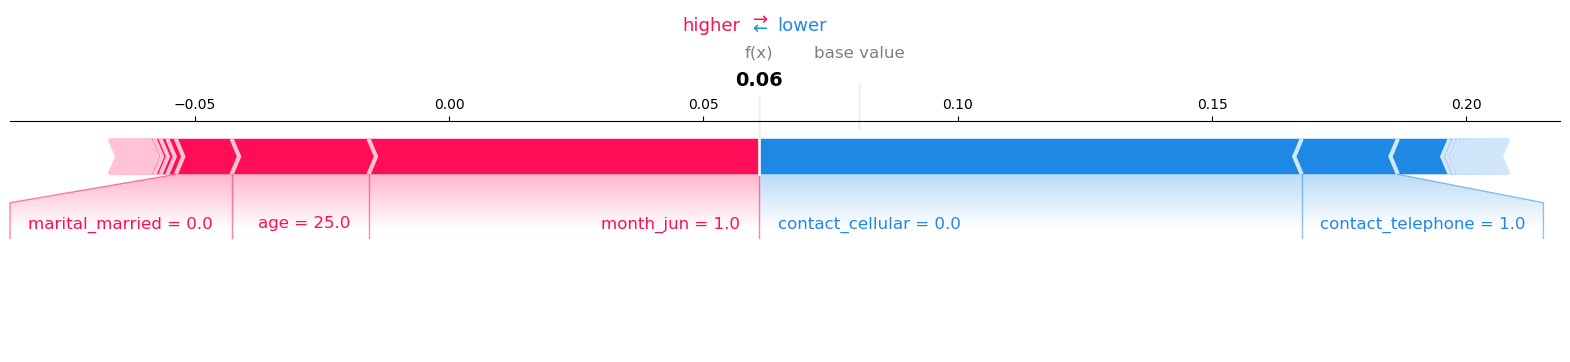

In [68]:
import shap 
visualize_result(result, request_records, expected_value)

In [69]:
transform_s3_url = f"s3://{bucket_name}/{bucket_prefix}/transform"

To create a transformer, use either option 1 or option 2.

#### Option 1: create a batch transformer from the trained estimator
You can use [`EstimatorBase.transformer()`](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.EstimatorBase.transformer) to create a transformer for an estimator:

In [70]:
model_name = f"from-idea-to-prod-transform-{strftime('%d-%H-%M-%S', gmtime())}"

transformer = estimator.transformer(
    instance_count=1,
    instance_type=train_instance_type,
    accept="text/csv",
    role=sm_role,
    output_path=transform_s3_url,
    model_name=model_name,
)

INFO:sagemaker:Creating model with name: from-idea-to-prod-transform-18-19-55-14


Go to the section **Run transform job**.

#### ROC curve

INFO:matplotlib.font_manager:generated new fontManager


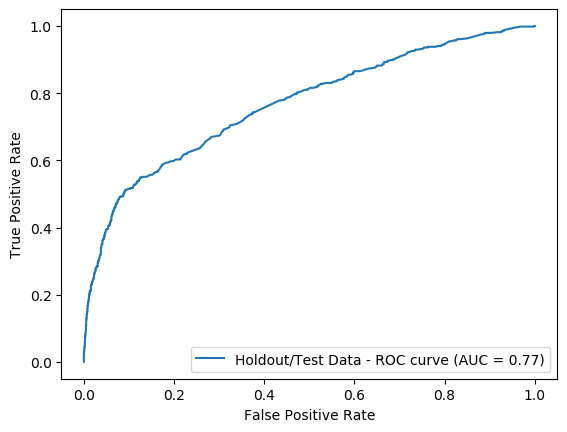

In [48]:
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt


fpr, tpr, thresholds = metrics.roc_curve(test_y, predictions)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='Holdout/Test Data - ROC curve')
display.plot()
plt.show()

#### Confusion matrix

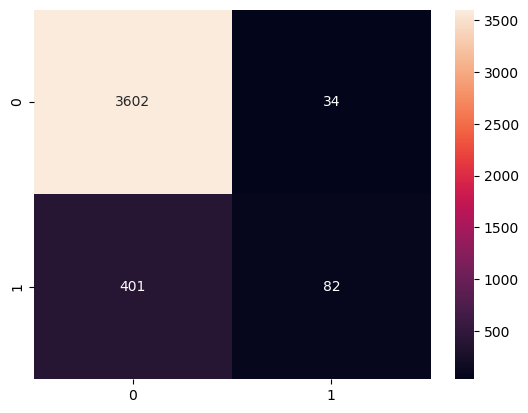

In [49]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(test_y, np.round(predictions))
f = sns.heatmap(cm, annot=True, fmt='d')
plt.show()

#### Precision-recall curve

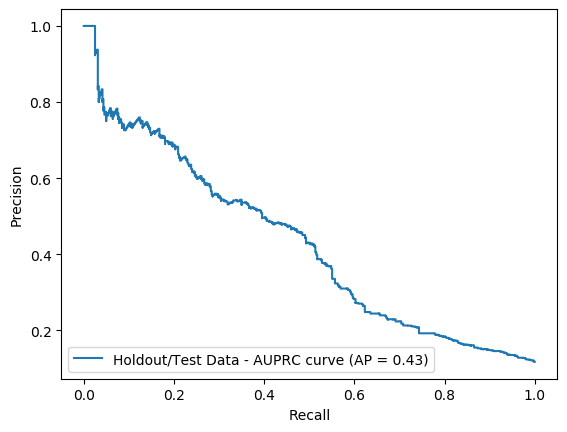

In [50]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(test_y, predictions)
average_precision= metrics.average_precision_score(test_y, predictions)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall, average_precision=average_precision, estimator_name='Holdout/Test Data - AUPRC curve')
pr_display.plot()
plt.show()

# Shutdown kernel and delete endpoint

In [125]:
# delete and endpoint that is running
import boto3
def delete_endpoint(endpoint_name):
    client = boto3.client('sagemaker')
    response = client.delete_endpoint(
        EndpointName=endpoint_name
    )
    return response['ResponseMetadata']['HTTPStatusCode'] == 200

endpoint_name =endpoint_name
print(delete_endpoint(endpoint_name))

True


In [126]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>